# Create the validation files
We remove randomly selected _square patches_ of data, since removing individual observations or tracks is not sufficient to assess the capacity of the model to reconstruct the gridded fields. 

The workflow is as follows:
1. Read the data from one of the file created in the notebook [prepare_data_netcdf](prepare_data_netcdf.ipynb).
2. Set a grid resolution (different from the final grid resolution) and count the number of observations per _square_ grid cell.
3. Randomly select the cells in order to obtain around 10% of the observations.
4. Separate the full dataset into a main dataset and a validation dataset.

In [67]:
using Pkg
using DIVAnd
Pkg.activate("../")
Pkg.resolve()
include("../scripts/CopepodsNN.jl")
include("../scripts/param.jl")
using CairoMakie
using GeoMakie
using JupyterFormatter
enable_autoformat()

  Activating project at `~/Projects/EMODnet/EMODnet-Biology/EMODnet-Biology-Interpolation-NN-Copepods`
     Project No packages added to or removed from `~/Projects/EMODnet/EMODnet-Biology/EMODnet-Biology-Interpolation-NN-Copepods/Project.toml`
    Manifest No packages added to or removed from `~/Projects/EMODnet/EMODnet-Biology/EMODnet-Biology-Interpolation-NN-Copepods/Manifest.toml`


6-element Vector{Function}:
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)

In [7]:
datafile1 = joinpath(dataprocdir, "Small_copepods_DINCAE_$(regionname).nc")
datafile2 = joinpath(dataprocdir, "Large_copepods_DINCAE_$(regionname).nc")

"../data/derived_data/Large_copepods_DINCAE_NortheastAtlantic.nc"

## Files and directories

In [8]:
if isfile(datafile1) & isfile(datafile2)
    @info("Data files already created")
else
    @error("Data files have to be created with read_copepods_data.ipynb")
end

[ Info: Data files already created


## Read observations in the region of interest

In [45]:
lon1, lat1, dates1, datavalues1, obsid1, varname1 =
    CopepodsNN.read_data_nc(datafile1, domaincompute);
lon2, lat2, dates2, datavalues2, obsid2, varname2 =
    CopepodsNN.read_data_nc(datafile2, domaincompute);
@info("Working on variables $varname1 and $varname2");

[ Info: Working on variables Small_copepods and Large_copepods


### Perform time subsetting
(needed if the time of the environmental datasets doesn't match the period covered by the CPR data).

In [46]:
if timesubsetting
    #datestart = fielddates_monthly_short[1]
    datestart = fielddates_monthly[1]
    yearstart = Dates.year(datestart)
    yearscpr = Dates.year.(datescpr)
    dateselection = findall(yearscpr .>= yearstart)
    @info("$(length(dateselection))")
    loncpr, latcpr, datescpr, datavalues, obsid = loncpr[dateselection],
    latcpr[dateselection],
    datescpr[dateselection],
    datavalues[dateselection],
    obsid[dateselection]
end

## Preparation of the files for validation
1. Find the cells where we have at least one observation
2. Remove 10% of those cells (approx).
### Compute number of observations per cell

In [47]:
data_num_valid = CopepodsNN.compute_data_num(
    lon1,
    lat1,
    dates1,
    longridvalid,
    latgridvalid,
    fielddates_monthly,
);

In [49]:
using Random
using StatsBase
Random.seed!(642);
indexdata = findall(data_num_valid .> 0)
ndatacells = length(indexdata)
index2remove = sample(1:ndatacells, Int64(round(ndatacells * 0.1)), replace = false)
length(index2remove) == length(unique(index2remove));
@show(index2remove[1:10], length(index2remove));

index2remove[1:10] = [25939, 21799, 37466, 6094, 42783, 23014, 23685, 23791, 29762, 37082]
length(index2remove) = 5115


Should be this if the domain is (-30, 12., 42., 70.)
```julia
index2remove[1:10] = [25939, 21799, 37466, 6094, 42783, 23014, 23685, 23791, 29762, 37082]
length(index2remove) = 5115
```

or this if domain is (-95, 27.5, 22.5, 79.0)

```julia
index2remove[1:10] = [34816, 29258, 50288, 8179, 57424, 30888, 31790, 31931, 39945, 49771]
length(index2remove) = 6866
```

## Prepare land-sea mask

In [50]:
contourfile = joinpath(auxdatadir, "outsidemask.json")
bathyfile = joinpath(auxdatadir, "gebco_30sec_16.nc")
contourfile_URL = CopepodsNN.get_dox_url("ODjaL0U8pJQllju")
bathyfile_URL = CopepodsNN.covariable_urls["gebco_30sec_16"]
CopepodsNN.download_check(contourfile, contourfile_URL)
CopepodsNN.download_check(bathyfile, bathyfile_URL)

xi, yi, mask = load_mask(bathyfile, true, longrid, latgrid, 0)
coordlist = CopepodsNN.read_polygon_json(contourfile);
CopepodsNN.edit_mask!(xi, yi, mask, coordlist);

[ Info: File ../data/aux_data/outsidemask.json already downloaded
[ Info: File ../data/aux_data/gebco_30sec_16.nc already downloaded


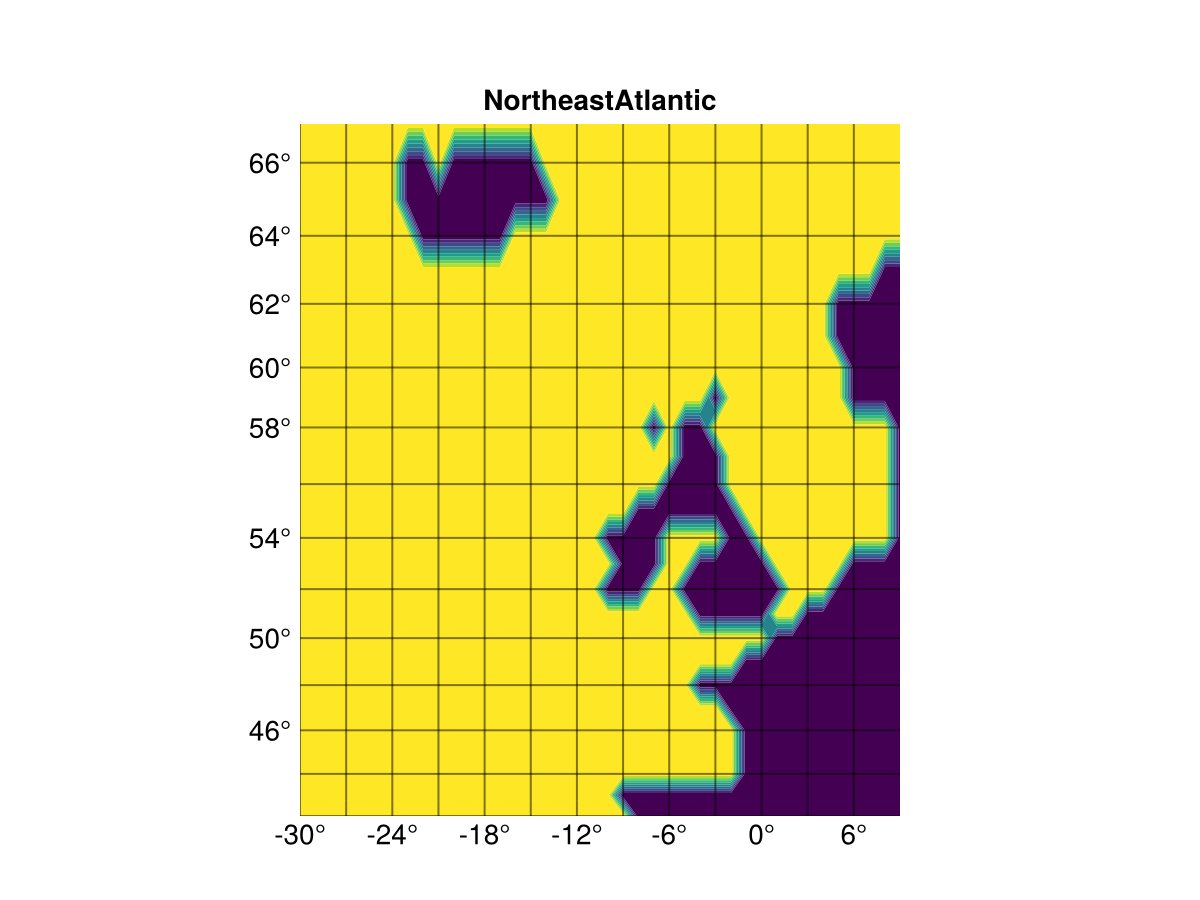

CairoMakie.Screen{IMAGE}


In [51]:
fig = Figure()
ax = GeoAxis(fig[1, 1], dest = "proj=merc", title = regionname)
xlims!(domain[1], domain[2])
ylims!(domain[3], domain[4])
contourf!(ax, xi, yi, mask)
display(fig)

### Check the percentage of removed data 

In [52]:
nremoved = sum(data_num_valid[indexdata[index2remove]])
ntotal = sum(data_num_valid)
pctremoved = nremoved / ntotal
@info("Number of removed observations: $(nremoved) ($(round(100 * pctremoved, digits=2))%)")

[ Info: Number of removed observations: 19732 (10.06%)


Should be this "NortheastAtlantic" domain
```julia
[ Info: Number of removed observations: 19732 (10.06%)      
```
or this for "NorthAtlantic" domain
```julia
[ Info: Number of removed observations: 25735 (9.97%)  
```

### Loop on the indices
Get the list of indices corresponding to observations to remove and to conserve.       
Create a figure to check.

In [68]:
function plot_validation_check(
    loncpr::Vector{Float64},
    latcpr::Vector{Float64},
    index2keep::Vector{Int64},
    index4validation::Vector{Int64},
    domain::Tuple,
    figname::AbstractString,
)

    pctvalid = round(
        100 * length(index4validation) / (length(index4validation) + length(index2keep)),
        digits = 2,
    )

    fig = Figure(size = (1200, 600))
    ax1 = CopepodsNN.create_geoaxis(
        fig,
        title = "Main dataset for $(varname1)\n($(length(index2keep)) obs)",
        ii = 1,
        jj = 1,
    )
    scatter!(ax1, loncpr[index2keep], latcpr[index2keep], markersize = 0.5, color = :black)
    xlims!(ax1, domain[1], domain[2])
    ylims!(ax1, domain[3], domain[4])

    ax2 = CopepodsNN.create_geoaxis(
        fig,
        title = "Validation dataset\n($(length(index4validation)), $(pctvalid)%)",
        ii = 1,
        jj = 2,
    )
    scatter!(
        ax2,
        loncpr[index4validation],
        latcpr[index4validation],
        markersize = 0.5,
        color = :black,
    )
    xlims!(ax2, domain[1], domain[2])
    ylims!(ax2, domain[3], domain[4])

    save(figname, fig)
    return nothing
end

plot_validation_check (generic function with 1 method)

In [59]:
length(index2keep) + length(index2remove), length(lon1), ntotal

(196051, 196051, 196051)

In [62]:
100 * length(index2remove) / ((length(index2remove) + length(index2keep)))

2.6090150011986677

In [55]:
if length(index2keep) + length(index2remove) !== length(lon1)
    @warn("Captain we have a problem with the number of observations")
end

In [69]:
plot_validation_check(
    lon1,
    lat1,
    index2keep,
    index2remove,
    domain,
    joinpath(figdir, "validation_check.png"),
)

LoadError: UndefVarError: `longridvalid` not defined in `Main.CopepodsNN`
Suggestion: check for spelling errors or missing imports.

In [66]:
longridvalid, latgridvalid

(-35.0:2.0:13.0, 37.0:2.0:71.0)

In [63]:
# Loop on the indices of the data to remove
# -----------------------------------------

index4validation = Int64[]
for ind in indexdata[index2remove]

    # Find the observations located in the 2°-by-2° zones
    lonsel =
        (lon1 .>= longridvalid[ind[1]] - Δlonvalid / 2) .&
        (lon1 .< longridvalid[ind[1]] + Δlonvalid / 2)
    latsel =
        (lat1 .>= latgridvalid[ind[2]] - Δlatvalid / 2) .&
        (lat1 .< latgridvalid[ind[2]] + Δlatvalid / 2)

    # Find the observations in the year and month of interest
    monthsel = Dates.month.(dates1) .== Dates.month(fielddates_monthly[ind[3]])
    yearsel = Dates.year.(dates1) .== Dates.year(fielddates_monthly[ind[3]])
    datasel = findall(lonsel .& latsel .& monthsel .& yearsel)

    append!(index4validation, datasel)
end

# Build the list of indices for the obs. to be conserved
# 
# length(index4validation) == nremoved ? @info("OK") : @error("The number of remove obs. is not correct")
index2keep = setdiff(collect(1:ntotal), index4validation)
length(index2keep) + length(index4validation) == ntotal

true

In [64]:
# Prepare a plot to check
figname = joinpath(figdir, replace(basename(datafile1), ".nc" => "_validation.png"))
plot_validation_check(lon1, lat1, index2keep, index4validation, domain, figname)

In [18]:
# Write the netCDF files
# ----------------------
# 
# * with prefix _main_: the data that will be interpolated
# * with prefix _valid_: the data that will be used for validation.

outputfilemain = joinpath(datadir, replace(basename(datafile1), ".nc" => "_main.nc"))
outputfilevalid =
    joinpath(datadir, replace(basename(datafile1), ".nc" => "_valid.nc"))

CopepodsNN.write_netcdf_CPR(
    outputfilemain,
    lon1[index2keep],
    lat1[index2keep],
    dates1[index2keep],
    datavalues1[index2keep],
    varname1,
    obsid1[index2keep],
    fielddates_monthly,
)

@time data_mean, data_num =
    CopepodsNN.get_data_mean_grid(
        lon1[index4validation],
        lat1[index4validation],
        dates1[index4validation],
        datavalues1[index4validation],
        longrid,
        latgrid,
        fielddates_monthly,
    )

outputfilevalid =
    joinpath(datadir, replace(basename(datafile1), ".nc" => "_valid.nc"))
isfile(outputfilevalid) ? rm(outputfilevalid) : @debug("not created")

  1.718312 seconds (22.14 M allocations: 1.293 GiB, 43.99% gc time, 34.98% compilation time)


In [19]:
@info("Writing validation file $(outputfilevalid)")
CopepodsNN.write_netcdf_grid(
    outputfilevalid,
    collect(longrid),
    collect(latgrid),
    fielddates_monthly,
    data_mean,
    data_num,
    mask,
    valex = -999.0,
    varname = varname1,
)

[ Info: Writing validation file ../data/derived_data/Large_copepods_DINCAE_valid.nc


In [23]:
monthref = 5
yearref = 1985

gooddates = findall((Dates.year.(dates1) .== yearref) .& (Dates.month.(dates1) .== monthref))    
fname = replace(basename(datafile1), ".nc" => "_$(monthref)_$(yearref).png")

fig = Figure()
ax = CopepodsNN.create_geoaxis(fig, title="$(fname)\n $(monthname(monthref)) $(yearref)")
scatter!(ax, lon1[gooddates], lat1[gooddates], datavalues1[gooddates], colorrange=(0, 27))
Colorbar(fig[1,2])
@info(fname)
save(joinpath(figdir, fname), fig)

[ Info: Large_copepods_DINCAE_5_1985.png
